In [1]:
import pickle
import pandas as pd
import numpy as np
import cv2

pck_1 = pickle.load(open('pck_1.txt', 'rb'), encoding='latin1')
pck_2 = pickle.load(open('pck_2.txt', 'rb'), encoding='latin1')
pck_3 = pickle.load(open('pck_3-2.txt', 'rb'), encoding='latin1')
pck_full = pickle.load(open('pck_full.txt', 'rb'), encoding='latin1')
sks_full = pickle.load(open('sks_full.data', 'rb'))
sks_3 = pickle.load(open('sks_3-2.data', 'rb'))
sks_1 = pickle.load(open('sks_1.data', 'rb'))
sks_2 = pickle.load(open('sks_2.data', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'pck_1.txt'

### Visualization

In [2]:
import logging
import math
import numpy as np
import cv2
import networkx as nx
import pandas as pd
import itertools
from sklearn.metrics import pairwise_distances

class PYPoses:
    def __init__(self):
        self.logger = self.__create_logger__()

        self.points_dic = {0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist", 5: "LShoulder",
                           6: "LElbow", 7: "LWrist", 8: "MidHip", 9: "RHip", 10: "RKnee", 11: "RAnkle",
                           12: "LHip", 13: "LKnee", 14: "LAnkle", 15: "REye", 16: "LEye", 17: "REar",
                           18: "LEar", 19: "LBigToe", 20: "LSmallToe", 21: "LHeel", 22: "RBigToe",
                           23: "RSmallToe", 24: "RHeel", 25: "Background"}

        self.pose_pairs = ((0, 1), (0, 15), (0, 16), (1, 2), (1, 5), (1, 8), (2, 3), (3, 4), (5, 6),
                           (6, 7), (8, 9), (8, 12), (9, 10), (10, 11), (11, 24), (11, 22), (12, 13),
                           (13, 14), (14, 19), (14, 21), (15, 17), (16, 18), (19, 20), (22, 23))
        
        self.pairs_labels = (0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1)

        self.joints = {'lshoulder': (1, 5, 6), 'rshoulder': (1, 2, 3), 'lelbow': (5, 6, 7), 'relbow': (2, 3, 4),
                       'lknee': (12, 13, 14), 'rknee': (9, 10, 11), 'lankle': (13, 14, 19), 'rankle': (10, 11, 22),
                       'lpelvis': (10, 9, 8), 'rpelvis': (13, 12, 8)}

    @staticmethod
    def __create_logger__():
        logger = logging.getLogger('TfPoseEstimatorRun')
        logger.handlers.clear()
        logger.setLevel(logging.DEBUG)
        ch = logging.StreamHandler()
        ch.setLevel(logging.DEBUG)
        formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
        ch.setFormatter(formatter)
        logger.addHandler(ch)
        return logger

    @staticmethod
    def __length_between_points__(p0, p1):
        return math.hypot(p1[0] - p0[0], p1[1] - p0[1])

    @staticmethod
    def __angle_between_points__(p0, p1, p2):
        a = (p1[0] - p0[0]) ** 2 + (p1[1] - p0[1]) ** 2
        b = (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2
        c = (p2[0] - p0[0]) ** 2 + (p2[1] - p0[1]) ** 2
        if a * b == 0:
            return -1.0
        return math.acos((a + b - c) / math.sqrt(4 * a * b)) * 180 / math.pi
    
    def __is_meaningful__(self, points: np.array) -> bool:
        found = False
        for pair in self.pose_pairs:
            partFrom = pair[0]
            partTo = pair[1]
            if points[partFrom] and points[partTo]:
                found = True
        return found
    
    def __get_angle_point__(self, human, pos):
        pos_list = self.joints[pos]
        pnts = []

        for i in range(3):
            if human[pos_list[i]][2] <= 0.1:
                print('component [%d] incomplete' % (pos_list[i]))
                return pnts

            pnts.append((int(human[pos_list[i]][0]), int(human[pos_list[i]][1])))
        return pnts

    def get_joint_angle(self, human, joint):
        pnts = self.__get_angle_point__(human, joint)
        if len(pnts) != 3:
            self.logger.info('component incomplete')
            return -1

        angle = 0
        if pnts is not None:
            angle = self.__angle_between_points__(pnts[0], pnts[1], pnts[2])
            self.logger.info('{} angle: {}'.format(joint, angle))
        return angle
    
    def get_points_dic(self):
        return self.points_dic

    def reconstruct_op(self, poseKeypoints, image, skeleton_mode='full', view_mode=True):
        if poseKeypoints.size < 3:
            return False, None
        else:
            skeletons = []
            for person in range(poseKeypoints.shape[0]):
                out = np.zeros_like(image)
                points = []
                for i in range(len(self.points_dic) - 1):
                    point = poseKeypoints[person][i, :2]
                    conf = poseKeypoints[person][i, 2]
                    x = int(point[0])
                    y = int(point[1])

                    # Add a point if it's confidence is higher than threshold.
                    points.append((int(x), int(y)) if conf > 0.3 else None)

                if skeleton_mode == 'partial':
                    partFrom = 1  # Neck
                    partTo = 8  # MidHip
                    if points[partFrom] and points[partTo]:
                        cv2.line(out, points[partFrom], points[partTo], (255, 255, 255), 2)
                        skeletons.append(cv2.cvtColor(out, cv2.COLOR_BGR2GRAY) != 0.)

                        if view_mode:
                            cv2.line(image, points[partFrom], points[partTo], (255, 74, 0), 2)
                            cv2.ellipse(image, points[partFrom], (1, 1), 0, 0, 360, (255, 255, 255), cv2.FILLED)
                            cv2.ellipse(image, points[partTo], (1, 1), 0, 0, 360, (255, 255, 255), cv2.FILLED)
                else:
                    for pair in self.pose_pairs:
                        partFrom = pair[0]
                        partTo = pair[1]

                        if points[partFrom] and points[partTo]:
                            cv2.line(out, points[partFrom], points[partTo], (255, 255, 255), 2)
                            if view_mode:
                                cv2.line(image, points[partFrom], points[partTo], (255, 74, 0), 2)
                                cv2.ellipse(image, points[partFrom], (1, 1), 0, 0, 360, (255, 255, 255), cv2.FILLED)
                                cv2.ellipse(image, points[partTo], (1, 1), 0, 0, 360, (255, 255, 255), cv2.FILLED)

                    skeletons.append(cv2.cvtColor(out, cv2.COLOR_BGR2GRAY) != 0.)

            if len(skeletons) > 0:
                return True, skeletons
            else:
                return False, None
            
    def create_graph(self, poseKeypoints):
        if poseKeypoints.size < 3:
            return False, None
        else:
            G = []
            for person in range(poseKeypoints.shape[0]):
                points = []
                for i in range(len(self.points_dic) - 1):
                    point = poseKeypoints[person][i, :2]
                    conf = poseKeypoints[person][i, 2]
                    x = int(point[0])
                    y = int(point[1])

                    # Add a point if it's confidence is higher than threshold.
                    points.append((int(x), int(y)) if conf > 0.3 else None)
                    
                graph = nx.Graph()
                labels = {}
                
                for pair in self.pose_pairs:
                    partFrom = pair[0]
                    partTo = pair[1]

                    if points[partFrom] and points[partTo]:
                        graph.add_edge(self.points_dic[partFrom], self.points_dic[partTo], 
                        weight=self.__length_between_points__(points[partFrom], points[partTo]))
                        labels[self.points_dic[partFrom]] = partFrom
                        labels[self.points_dic[partTo]] = partTo
                
                if graph.size() > 0:
                    nx.set_node_attributes(graph, labels, 'label')
                    G.append(graph)
                    
            if len(G) > 0:
                return True, G
            else:
                return False, None
            
    def empty_dataframe(self):
        columns = ['{}-{}'.format(self.points_dic[p1],self.points_dic[p2]) for p1, p2 in self.pose_pairs]
        [columns.append(j) for j in self.joints.keys()]
        columns.append('label')
        return pd.DataFrame(columns=columns)
    
    def large_empty_dataframe(self):
        point_comb = list(itertools.combinations(range(25), 2))
        joint_comb = list(itertools.combinations(range(25), 3))
        points = ['{}-{}'.format(self.points_dic[p1],self.points_dic[p2]) for p1, p2 in point_comb]
        joints = ['{}-{}-{}'.format(self.points_dic[p1],self.points_dic[p2],self.points_dic[p3]) for p1,p2,p3 in joint_comb]
        columns = points+joints
        columns.append('label')
        return pd.DataFrame(columns=columns)
            
    def create_pandas_frames(self, poseKeypoints, df, metric):
        if poseKeypoints.size < 3:
            return False, None
        
        def built_person(person):
            points = []
            for i in range(len(self.points_dic) - 1):
                point = person[i, :2]
                conf = person[i, 2]
                x = int(point[0])
                y = int(point[1])

                # Add a point if it's confidence is higher than threshold.
                points.append((int(x), int(y)) if conf > 0.3 else None)

            sk_dict = dict(zip(df.columns, np.full(len(df.columns), np.nan)))
            found = False

            for pair in self.pose_pairs:
                partFrom = pair[0]
                partTo = pair[1]

                if points[partFrom] and points[partTo]:
                    key = '{}-{}'.format(self.points_dic[partFrom],self.points_dic[partTo])
                    p1, p2 = np.asarray(points[partFrom]).reshape(1,2), np.asarray(points[partTo]).reshape(1,2)
                    val = pairwise_distances(p1, p2, metric=metric).mean()
                    sk_dict[key] = val
                    found = True

            for key, val in self.joints.items():
                p0, p1, p2 = val
                if points[p0] and points[p1] and points[p2]:
                    ang = self.__angle_between_points__(points[p0],points[p1],points[p2])
                    sk_dict[key] = ang
                        
            return found, sk_dict
             
        valid = 0
        
        if poseKeypoints.shape[0] == 1:
            found, sk_dict = built_person(poseKeypoints[0])
            if found:
                df.loc[len(df)] = sk_dict
                valid += 1
                
        elif poseKeypoints.shape[0] == 25:
            found, sk_dict = built_person(poseKeypoints)
            if found:
                df.loc[len(df)] = sk_dict
                valid += 1
        else:
            for person in poseKeypoints:
                found, sk_dict = built_person(person)
                if found:
                    df.loc[len(df)] = sk_dict
                    valid += 1

        if valid > 0:
            return True, valid
        else:
            return False, None
            
    def create_large_pandas_frames(self, poseKeypoints, df, metric):
        if poseKeypoints.size < 3:
            return False, None
        
        def built_person(person):
            points = []
            for i in range(len(self.points_dic) - 1):
                point = person[i, :2]
                conf = person[i, 2]
                x = int(point[0])
                y = int(point[1])

                # Add a point if it's confidence is higher than threshold.
                points.append((int(x), int(y)) if conf > 0.3 else None)

            sk_dict = dict(zip(df.columns, np.full(len(df.columns), np.nan)))
            found = False

            if not self.__is_meaningful__(points):
                pass
            else:
                point_comb = list(itertools.combinations(range(25), 2))
                joint_comb = list(itertools.combinations(range(25), 3))

                for pair in point_comb:
                    partFrom = pair[0]
                    partTo = pair[1]

                    if points[partFrom] and points[partTo]:
                        key = '{}-{}'.format(self.points_dic[partFrom],self.points_dic[partTo])
                        p1, p2 = np.asarray(points[partFrom]).reshape(1,2), np.asarray(points[partTo]).reshape(1,2)
                        val = pairwise_distances(p1, p2, metric=metric).mean()
                        sk_dict[key] = val
                        found = True

                for val in joint_comb:
                    p0, p1, p2 = val
                    if points[p0] and points[p1] and points[p2]:
                        ang = self.__angle_between_points__(points[p0],points[p1],points[p2])
                        key = '{}-{}-{}'.format(self.points_dic[p0], self.points_dic[p1], self.points_dic[p2])
                        sk_dict[key] = ang
                
            return found, sk_dict
            
        valid = 0
        
        if poseKeypoints.shape[0] == 1:
            found, sk_dict = built_person(poseKeypoints[0])
            if found:
                df.loc[len(df)] = sk_dict
                valid += 1
                
        elif poseKeypoints.shape[0] == 25:
            found, sk_dict = built_person(poseKeypoints)
            if found:
                df.loc[len(df)] = sk_dict
                valid += 1
        else:
            for person in poseKeypoints:
                found, sk_dict = built_person(person)
                if found:
                    df.loc[len(df)] = sk_dict
                    valid += 1
            
        if valid > 0:
            return True, valid
        else:
            return False, None

In [ ]:
import cv2
from cv2 import dnn_superres
# Create an SR object - only function that differs from c++ code
sr = dnn_superres.DnnSuperResImpl_create()
# Read the desired model
path = "/home/nrvc/Downloads/EDSR_x4.pb"
sr.readModel(path)
# Set the desired model and scale to get correct pre- and post-processing
sr.setModel("edsr", 4)

### Running

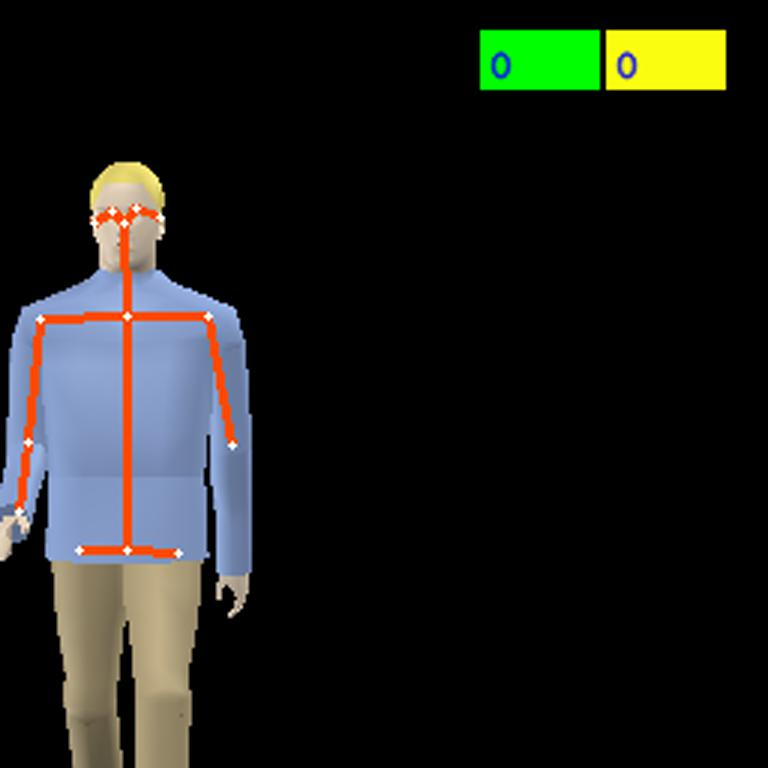

IndexError: list index out of range

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, Image
import PIL
from io import BytesIO
import time
import xgboost as xgb


def array_to_image(a, fmt='jpeg'):
    #Create binary stream object
    f = BytesIO()
    #Convert array to binary stream object
    PIL.Image.fromarray(a).save(f, fmt)
    return Image(data=f.getvalue())      

def puttext(pos,text,img):
    font = cv2.FONT_HERSHEY_SIMPLEX 
    fontScale = 0.35
    color = (0, 0, 255) 
    thickness = 1
    image = cv2.putText(img, text, pos, font,fontScale, color, thickness, cv2.LINE_AA)
    return image
    

d = display("", display_id=1)
op = PYPoses()
grn = [0,255,0]
ylw = [250,253,15]

model = pickle.load(open('weights_xgb.data', 'rb'))
classes = ['-1','90','135','180','225','270','315','0','45']

y_a, ypred_a = [], []

for i in range(len(pck_full)):
    img = pck_1[i][0]
#     img = pck_2[i][0]
#     img = pck_3[i][0]
#     img = pck_full[i][0]
    img = img[::-1]
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img[10:30,160:200] = grn
    img[10:30,202:242] = ylw
    
    op.reconstruct_op(sks_1[i], img)
#     op.reconstruct_op(sks_2[i], img)
#     op.reconstruct_op(sks_3[i], img)
#     op.reconstruct_op(sks_full[i], img)
    df = op.large_empty_dataframe()
    op.create_large_pandas_frames(sks_1[i], df, 'braycurtis')
#     op.create_large_pandas_frames(sks_2[i], df, 'braycurtis')
#     op.create_large_pandas_frames(sks_3[i], df, 'braycurtis')
#     op.create_large_pandas_frames(sks_full[i], df, 'braycurtis')
    try:
        y = model.predict(df.iloc[:,:-1])
    except:
        y = [0]

    degrees = pck_1[i][1]
#     degrees = pck_2[i][1]
    degrees = (degrees*180)/np.pi + 90
    if degrees >= 360:
        degrees -= 360
    if degrees < 0:
        degrees += 360
#     degrees = pck_3[i][1]
#     degrees = pck_full[i][1] - 45
    
    img = puttext((163,25), str(round(degrees)), img)
    img = puttext((205,25), classes[y[0]], img)
    
    y_a.append(round(degrees))
    ypred_a.append(int(classes[y[0]]))
    
#     img = sr.upsample(img)
    img = cv2.resize(img, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
    im = array_to_image(img)
    d.update(im)
#     time.sleep(0.03)

### plot

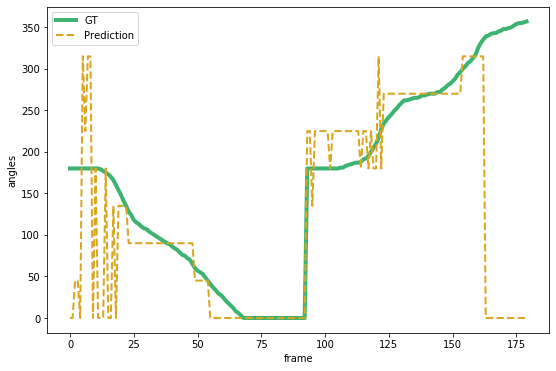

In [21]:
# Data
y_a = [0 if i == 360 else i for i in y_a]
df=pd.DataFrame({'x':(range(len(y_a))),'GT': y_a, 'Prediction':ypred_a  })

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.set_ylabel('angles')
ax.set_xlabel('frame')
# multiple line plot
plt.plot( 'x', 'GT', data=df, marker='', markerfacecolor='blue', markersize=12, color='mediumseagreen', linewidth=4)
plt.plot( 'x', 'Prediction', data=df, marker='', color='goldenrod', linewidth=2, linestyle='dashed')
plt.legend()


In [ ]:
len(y_a)